###  Conversion Analysis on Web Design

### 1. Introduction
For this project, we will be analyzing the results of an A/B test run by an e-commerce website. The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

### 2. Import data & data cleaning

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
df=pd.read_csv('sample ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,1
3,853541,28:03.1,treatment,new_page,1
4,864975,52:26.2,control,old_page,1


In [49]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [50]:
#missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### EDA

In [51]:
# Function to parse the timestamp
def parse_timestamp(ts):
    minutes, seconds_fraction = ts.split(':')
    seconds, fraction = seconds_fraction.split('.')
    # Convert to a 'timedelta' object
    return pd.to_timedelta(f'{int(minutes)%60} minutes {int(seconds)%60} seconds {int(fraction)} milliseconds')


In [52]:
# Apply the function to the timestamp column
df['timestamp'] = df['timestamp'].apply(parse_timestamp)


In [53]:
# Group by the time and calculate conversion rate for each group
df['minute'] = df['timestamp'].dt.components.minutes
conversion_rates = df.groupby(['minute', 'group']).agg({'converted': 'mean'}).reset_index()


In [54]:
# Pivot the data to have minutes on the index and groups as columns
pivot_df = conversion_rates.pivot(index='minute', columns='group', values='converted')


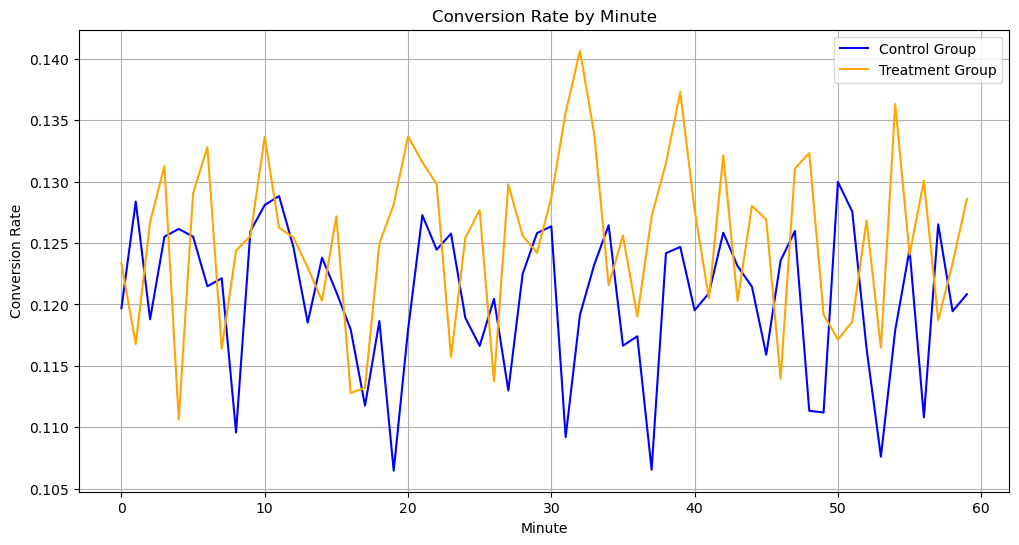

In [55]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['control'], label='Control Group', color='blue')
plt.plot(pivot_df.index, pivot_df['treatment'], label='Treatment Group', color='orange')

plt.title('Conversion Rate by Minute')
plt.xlabel('Minute')
plt.ylabel('Conversion Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### Check if group aligns with landing_page

In [19]:
((df.group=='treatment') & (df.landing_page=='old_page')).sum()


1965

In [20]:
((df.group=='control') & (df.landing_page=='new_page')).sum()

1928

In [21]:
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))
df = df[-df['misaligned']]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
 5   misaligned    290585 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 13.6+ MB


In [23]:
df.user_id.nunique()

290584

In [24]:
df['user_id'].value_counts().sort_values(ascending=False).head()

773192    2
834487    1
936923    1
679687    1
719014    1
Name: user_id, dtype: int64

In [25]:
df['user_id'].value_counts().sort_values(ascending=False).head()

773192    2
834487    1
936923    1
679687    1
719014    1
Name: user_id, dtype: int64

In [26]:
# make assumption:
## let's assume
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,37:58.8,treatment,new_page,1,False
2893,773192,55:59.6,treatment,new_page,0,False


In [27]:
df.drop(1899, axis = 0,inplace = True)

In [28]:
df['user_id'].value_counts().sort_values(ascending=False).head()

851104    1
834487    1
936923    1
679687    1
719014    1
Name: user_id, dtype: int64

In [33]:
# How many users in each group?
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


In [35]:
# Conversion rate in each group
df[['user_id', 'group', 'converted']].groupby('group').agg({
    'user_id': 'count', 
    'converted': ['mean', 'sum']
})


user_id converted       
            count      mean    sum
group                             
control    145274  0.120386  17489
treatment  145310  0.125353  18215

###  3. Analyze results

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

null:  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  <=0

alternative:  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  >0

In [36]:
convert_old = df[df.group=='control'].converted.sum()
convert_new = df[df.group=='treatment'].converted.sum()
n_old = len(df[df.group=='control'].converted)
n_new= len(df[df.group=='treatment'].converted)

convert_old, convert_new, n_old, n_new

(17489, 18215, 145274, 145310)

In [38]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new},'Converts': {'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
Control,145274,17489,12.0%
Test,145310,18215,12.5%


### 3.1 Z-test in our way

In [41]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

In [42]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [43]:
z_value = z_test(p1,p0,n1,n0)
z_value

4.077481782861739

In [44]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

2.276304781123617e-05

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

### 3.2 Z-test in Statsmodels

In [45]:
import statsmodels.api as sm

In [46]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(4.077481782861739, 2.276304781118429e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page